# Eigenfaces


This notebook demonstrates two applications of Eigenface. 


1. **Facial Recognition:** By projecting new faces onto the subspace spanned by the extracted eigenfaces, we can effectively compare them to known faces and establish matches or non-matches.
2. **Image Compression:** Eigenfaces can also be leveraged for image compression. By representing images using a smaller set of eigenfaces and corresponding coefficients, we can significantly reduce the storage requirements while preserving essential facial features.

In [2]:
import os
from copy import deepcopy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

## AT&T Database of Faces


**You can download the dataset from various sources, including:**

* <a href="https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/data" target="_blank">Kaggle</a>

* <a href="https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/" target="_blank">The AT&T Research Laboratories website</a>

In [3]:
def load_faces(faces_directory):
    """Loads facial images from the AT&T Face Database.

    Args:
        faces_directory (str): The path to the AT&T Face Database directory. 
                               which contains training and testing folders.

    Returns:
        np.ndarray: A NumPy array containing the loaded facial images.
    """
    faces = []

    for sub_dir in ['training', 'testing']:
        current_directory = os.path.join(faces_directory, sub_dir)
        for subject in os.listdir(current_directory):
            subject = os.path.join(current_directory, subject)
            if os.path.isdir(subject):
                
                subject_images_name = os.listdir(subject)
                subject_images = [cv2.imread(os.path.join(subject, image_name), cv2.IMREAD_GRAYSCALE) 
                                 for image_name in subject_images_name]
                faces.extend(subject_images)

    faces = np.array(faces) 
    return faces / 255


def split_test_train(data, test_size=30, holdout_subjects=1):
    """Splits a dataset into training and testing sets, ensuring a fixed number of subjects are held out for testing.

    Args:
        data (np.ndarray): The input data to be split.
        test_size (int, optional): The total number of samples to be used for testing. Defaults to 30.
        holdout_subjects (int, optional): The number of subjects to hold out for testing. Defaults to 1.

    Returns:
        tuple: A tuple containing the training and testing sets as NumPy arrays.
    """
    holdout_size = holdout_subjects * 10
    holdout_set = data[:holdout_size]
    remaining_data = deepcopy(data[holdout_size:])
    
    np.random.shuffle(remaining_data)
    test_set = np.concatenate((holdout_set, remaining_data[:test_size - holdout_size]))
    train_set = remaining_data[test_size - holdout_size:]
    
    return train_set, test_set

### We reserve two subjects (completely) plus 20 random images as a test set.
* These images are not used in the process of calculating eigenfaces.

images shape (H×W): 112×92
There are 360 images in the training set.
There are 40 images in the testing set.


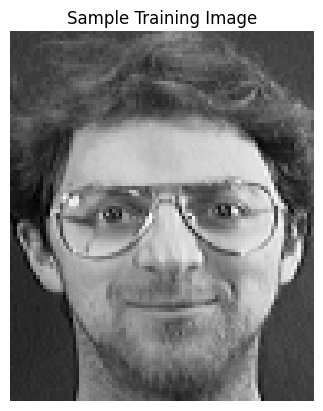

In [7]:
np.random.seed(0)
test_size = 40
holdout_subjects = 2

att_data_directory = r'data\faces'
faces = load_faces(att_data_directory)
train_images, test_images = split_test_train(faces, test_size=test_size, holdout_subjects=holdout_subjects)

height, width = train_images[0].shape

print(f'images shape (H×W): {height}×{width}')
print(f'There are {len(train_images)} images in the training set.')
print(f'There are {len(test_images)} images in the testing set.')

plt.imshow(train_images[0], cmap='gray')
plt.title('Sample Training Image')
plt.axis('off')
plt.show()

## Description of the procedure

Based on <a href="https://en.wikipedia.org/wiki/Eigenface#Generation" target="_blank">Wikipedia</a>:  

To create a set of eigenfaces, one must:

1. **Prepare a training set of face images:** 
    1. The pictures constituting the training set should have been taken under the same lighting conditions, and must be normalized to have the eyes and mouths aligned across all images. 
    2. They must also be all resampled to a common pixel resolution (e.g., `r × c`). 
    3. Each image is treated as one vector, simply by concatenating the rows of pixels in the original image, resulting in a single column with `r × c` elements. For this implementation, it is assumed that all images of the training set are stored in a single matrix `T`, where each column of the matrix is an image.

**Note:** 
   * **`train_images` in code corresponds to `T`.**
   * The AT&T Database of Faces provides images that are already aligned and have consistent lighting conditions.

In [8]:
if train_images.shape[0] != height*width:
    train_images = train_images.reshape(train_images.shape[0], -1).T
    test_images = test_images.reshape(test_images.shape[0], -1).T
    
print(f'Training matrix Shape: {train_images.shape}')

Training matrix Shape: (10304, 360)


2. **Subtract the mean:**   
   * The average image `a` has to be calculated and then subtracted from each original image in `T`.

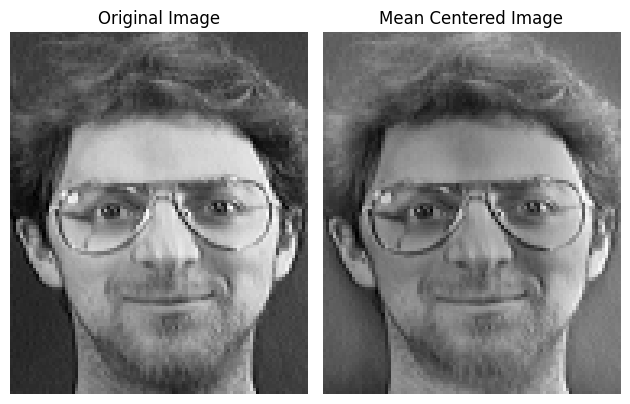

In [9]:
average_face = np.mean(train_images, axis=1)
mean_centered_train_images = train_images - average_face.reshape(-1, 1)

plt.subplot(1, 2, 1)
plt.imshow(train_images[:, 0].reshape(height, width), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_centered_train_images[:, 0].reshape(height, width), cmap='gray')
plt.title('Mean Centered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

3. **Calculate the eigenvectors and eigenvalues of the covariance matrix :**

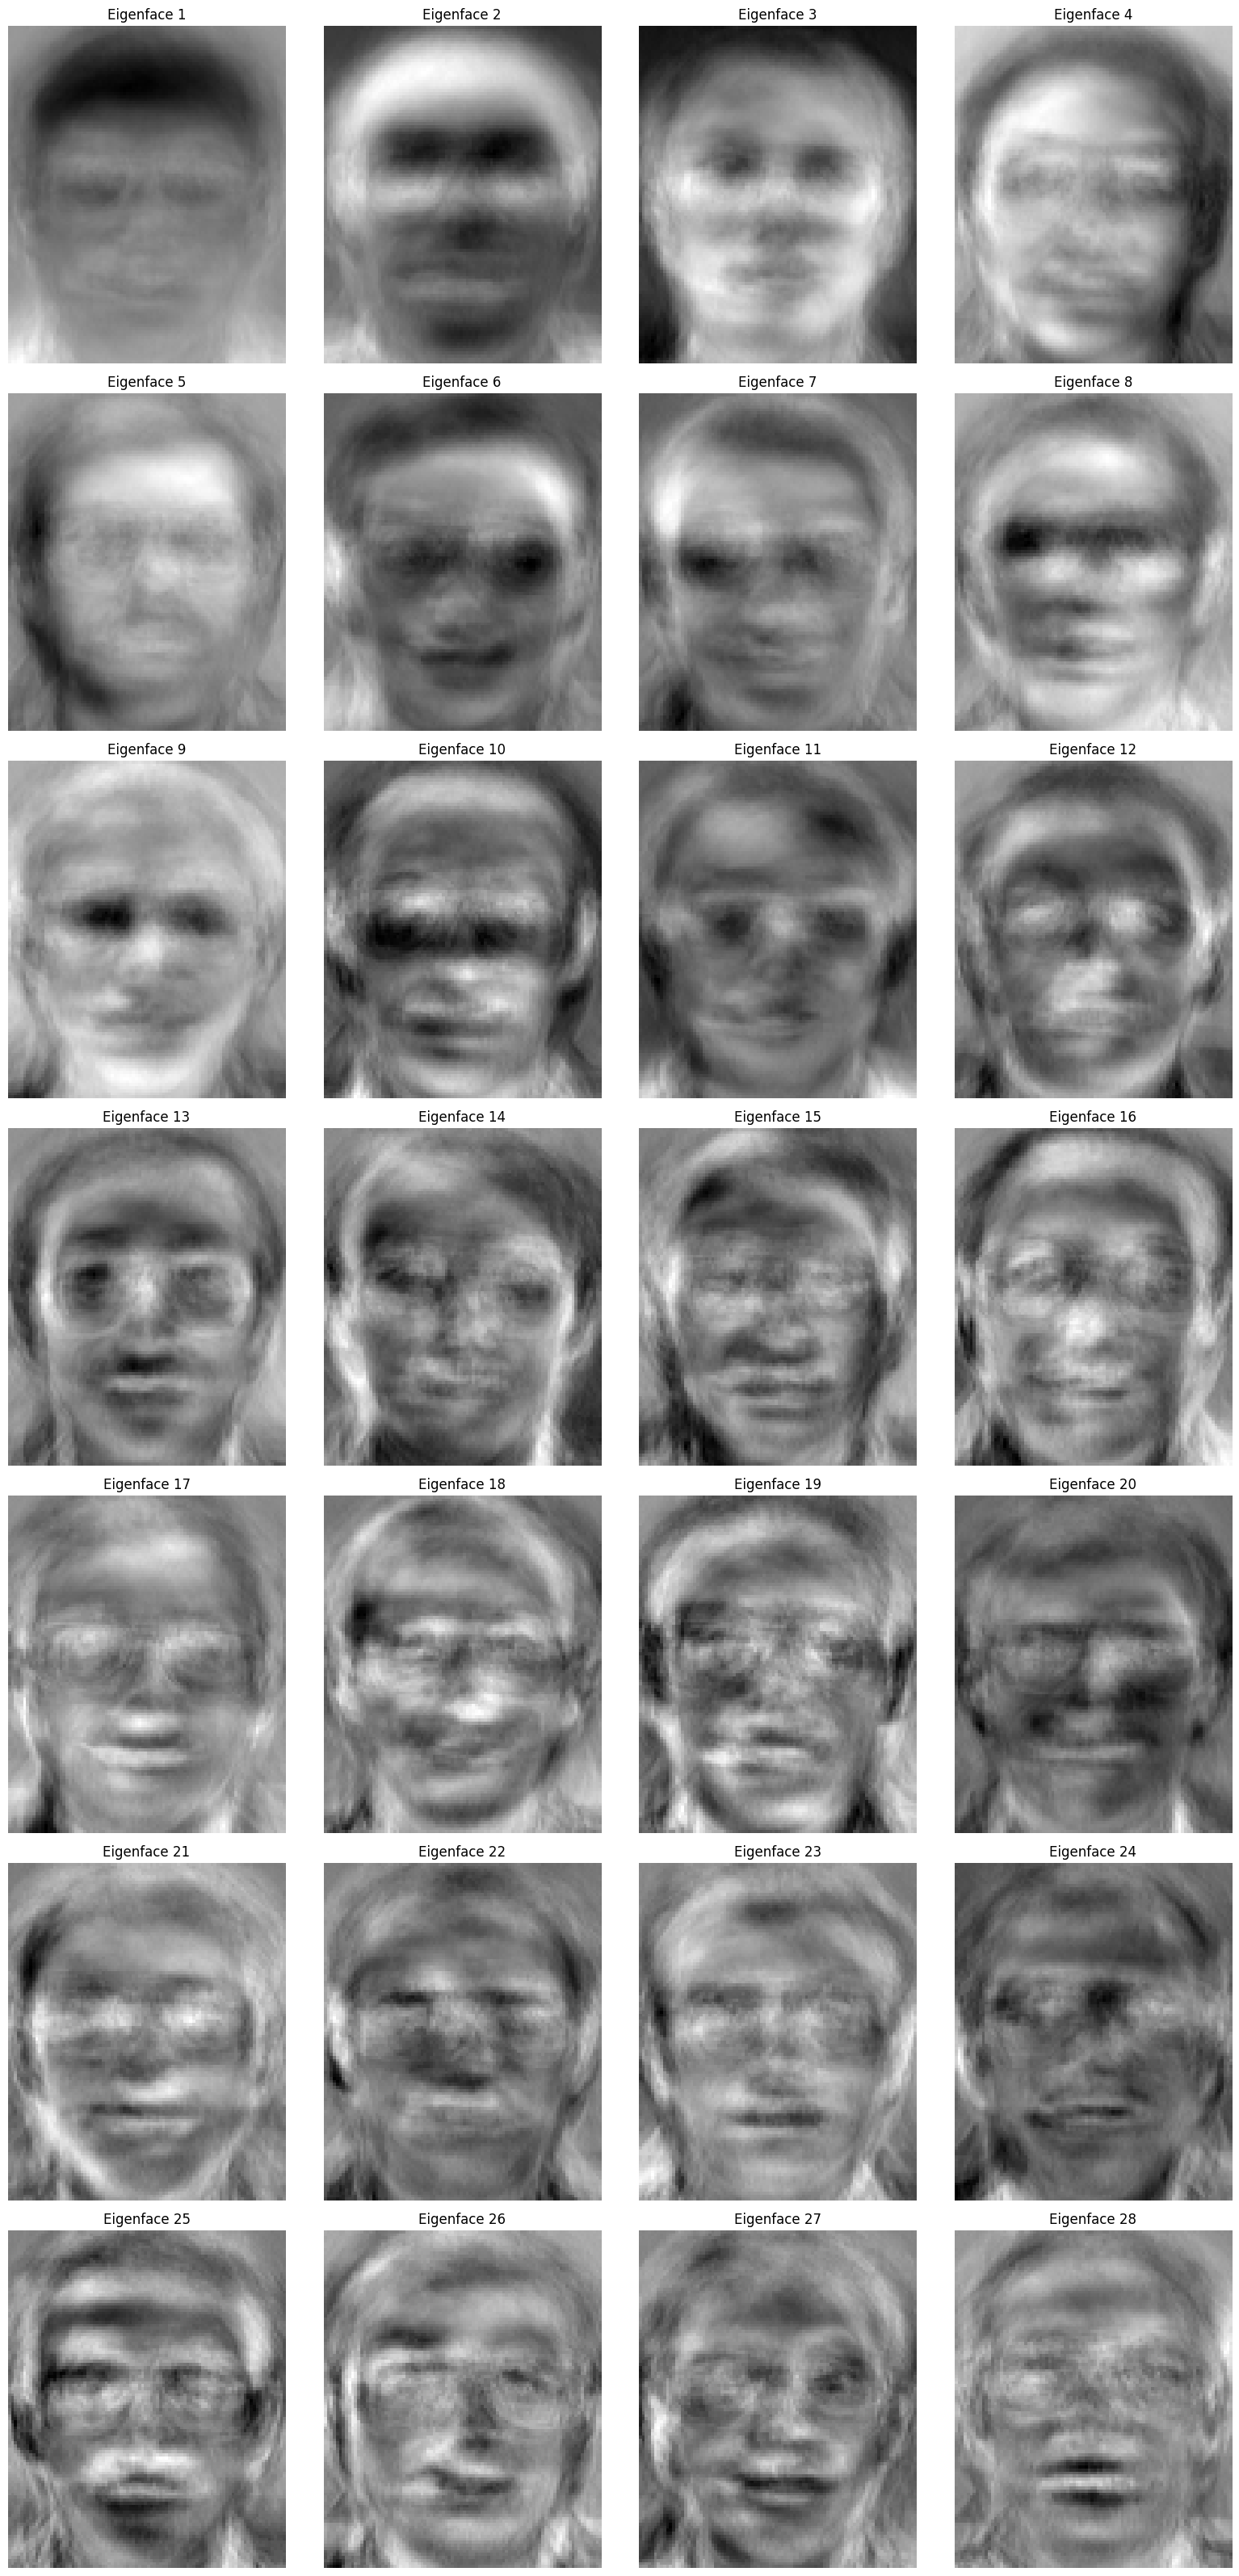

In [10]:
eigenfaces, *_ = np.linalg.svd(mean_centered_train_images, full_matrices=False)

plt.figure(figsize=[16, 32])
for i, eigenface in enumerate(eigenfaces.T):
    if i > 27: 
        break
    plt.subplot(7, 4, i+1)
    plt.imshow(eigenfaces.T[i].reshape(height, width), cmap='gray')
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Facial Recognition

Projecting faces onto eigenfaces involves decomposing each face image into a linear combination of the principal components (eigenfaces). The coefficients of this linear combination are the weights that represent the contribution of each eigenface to the original image.

  
* `X`: The matrix of centered images (each column is a flattened image).
* `E`: The matrix of eigenfaces (each column is an eigenface).  
* `C`: The matrix of coefficients.

The formula to obtain the coefficients will be:
$$ C = E^T \times X $$

Once you have the coefficients for each image, you can compare them to find the closest match. The idea is to calculate the __Euclidean distance__ between the coefficients of a new image and the coefficients of the known images. The image with the smallest distance is considered the closest match.

In [11]:
def calculate_coefficients(X, eigenfaces, mean_face):
    """Calculates the coefficients for projecting faces in X onto the eigenface space.

    Args:
      X (np.ndarray): A matrix of flattened face images (each column represents a face).
      eigenfaces (np.ndarray): A matrix containing the eigenfaces (each column is an eigenface).
      mean_face (np.ndarray): The average face vector.

    Returns:
      np.ndarray: A matrix containing the coefficients for each image in X. Each column represents the weights 
      associated with the eigenfaces for the corresponding image in X.
    """
    centered_X = (X.T - mean_face).T
    coefficients = np.dot(eigenfaces.T, centered_X)
    return coefficients


def recognize_face(new_face, eigenfaces, mean_face, training_coefficients):
    """Recognizes a face by projecting it onto the eigenface space and finding the closest match.

    Args:
        new_face (np.ndarray): The new face image to be recognized.
        eigenfaces (np.ndarray): The matrix of eigenfaces.
        mean_face (np.ndarray): The mean face vector.
        training_coefficients (np.ndarray): A matrix of coefficients for the training images.

    Returns:
        tuple: A tuple containing the recognized index and the distance to the closest match.
    """
    new_coefficients = calculate_coefficients(new_face, eigenfaces, mean_face)

    distances = np.linalg.norm(training_coefficients - new_coefficients, axis=1)

    recognized_index = np.argmin(distances)

    return recognized_index, distances[recognized_index]


def mask_image_overlap(face_vectors1, face_vectors2):
    """Creates a boolean mask indicating which faces in face_vectors1 are also in face_vectors2.
    
    Args:
        face_vectors1 (np.ndarray): The first 2D array (each column represents a face).
        face_vectors2 (np.ndarray): The second 2D array (each column represents a face).

    Returns:
        np.ndarray: A boolean array where `False` indicates a common vector.
    """
    common_indices = np.ones((face_vectors1.shape[1]), dtype=bool)
    
    for i, face in enumerate(face_vectors1.T):
        tiled_face = np.tile(face, (face_vectors2.shape[1], 1)).T
        if np.any(
            np.all(tiled_face == face_vectors2, axis=0)
        ):
            common_indices[i] = False
    return common_indices

* To improve face recognition, we used all available training images for each subject (except those held out for testing) and averaged their coefficients. This reduces the number of coefficients and speeds up the algorithm.

* We also used three images of each subject that were held out during the eigenface calculation process and calculated their coefficients just like the other training images. This approach mimics the scenario where these faces were added to the system afterward. We then removed these three corresponding images from the test set.

**Note:**  
   * The removal of the three images mentioned above is hard-coded. If you change the number of holdout subjects, you’ll need to manually update the last line of the code to remove the corresponding images from the test set.

In [12]:
subjects = np.array(np.array_split(faces.reshape(faces.shape[0], -1), 40))

subjects_coefficients = []
subjects_images = []

for i, subject in enumerate(subjects):
    subject = subject.T
    mask = mask_image_overlap(subject, test_images)

    if not np.any(mask):
        mask[0:3] = True
    
    known_subject_images = subject[:, mask]
    known_subject_coefficients = calculate_coefficients(known_subject_images, eigenfaces, average_face)

    subjects_images.append(known_subject_images[:, 0])  # an image (which is not in the test set) to represent the subject.
    subjects_coefficients.append(known_subject_coefficients.mean(axis=1))
      
subjects_coefficients = np.array(subjects_coefficients)
subjects_images = np.array(subjects_images)

if test_images.shape[1] == test_size:
    test_images = np.hstack((test_images[:, 3:10], test_images[:, 13:]))

### Results

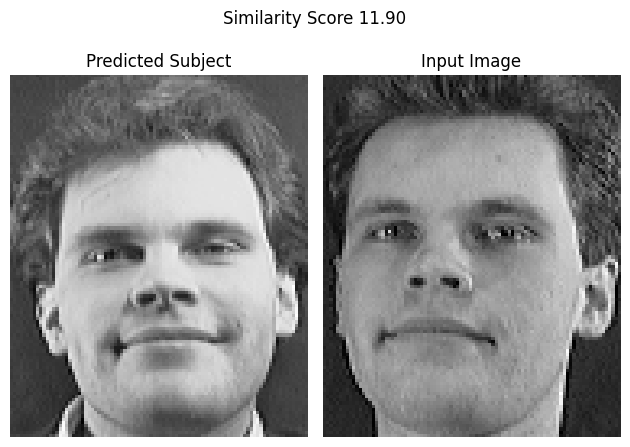

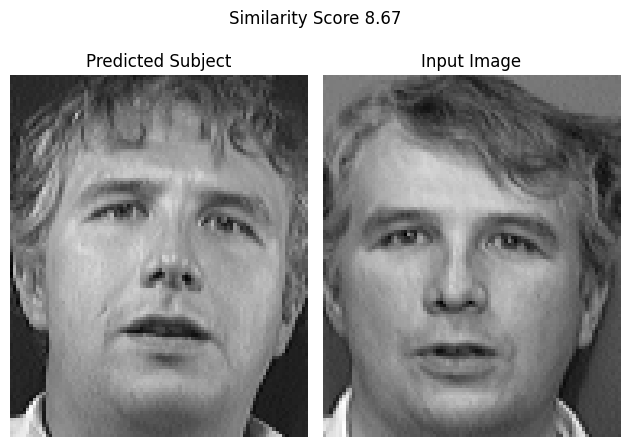

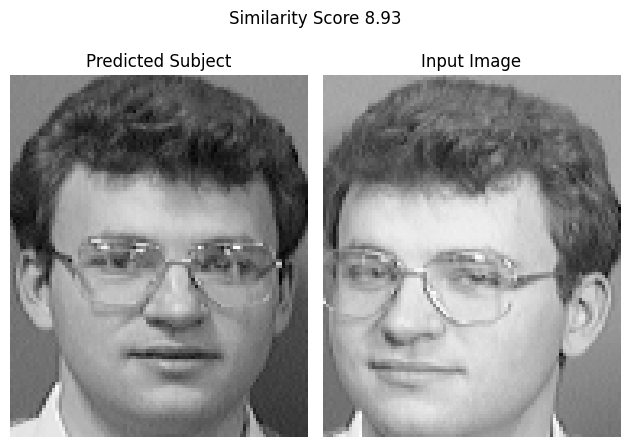

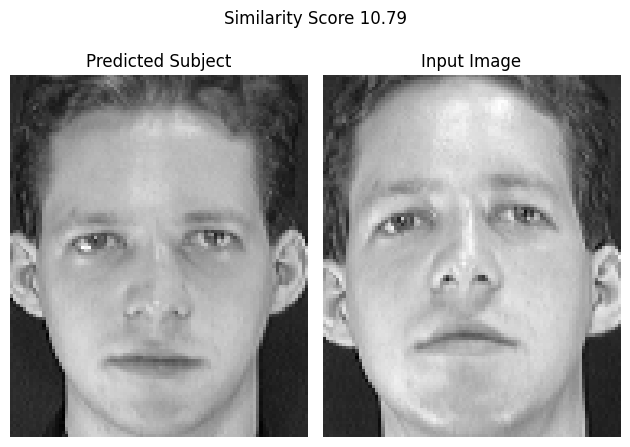

In [13]:
random_samples = np.random.randint(0, high=test_images.shape[1], size=4)

for i in random_samples:
    index, score = recognize_face(test_images[:, i], eigenfaces, average_face, subjects_coefficients)

    plt.suptitle(f'Similarity Score {score:.2f}')
    
    plt.subplot(1, 2, 1)
    plt.imshow(subjects_images[index].reshape(height, width), cmap='gray')
    plt.axis('off')
    plt.title('Predicted Subject')

    plt.subplot(1, 2, 2)
    plt.imshow(test_images[:, i].reshape(height, width), cmap='gray')
    plt.axis('off')
    plt.title('Input Image')

    plt.tight_layout()
    plt.show()

In [14]:
def create_labels(desired_faces, all_faces):
    """Creates labels for a set of desired faces by identifying their corresponding subjects.

    Args:
        desired_faces (np.ndarray): A 2D array where each column represents a face from a subset of the dataset.
        all_faces (np.ndarray): A 2D array where each column represents a face from the entire dataset.

    Returns:
        List[int]: A list of labels where each label corresponds to the subject number.
    """
    indices = []
    
    for face in desired_faces.T:
        tiled_face = np.tile(face, (all_faces.shape[1], 1)).T
        mask = np.all(tiled_face == all_faces, axis=0)
        
        if np.any(mask):
            indices.append(np.where(mask)[0].item())
    
    labels = [index // 10 for index in indices]
    return labels

In [15]:
test_labels = create_labels(test_images, faces.reshape(faces.shape[0], -1).T)
train_labels = create_labels(train_images, faces.reshape(faces.shape[0], -1).T)

test_predictions = [
    recognize_face(test_image, eigenfaces, average_face, subjects_coefficients)[0]
    for test_image in test_images.T
]

train_predictions = [
    recognize_face(train_image, eigenfaces, average_face, subjects_coefficients)[0]
    for train_image in train_images.T
]

test_accuracy = accuracy_score(test_labels, test_predictions)
train_accuracy = accuracy_score(train_labels, train_predictions)

test_f1 = f1_score(test_labels, test_predictions, average='macro')
train_f1 = f1_score(train_labels, train_predictions, average='macro')

print(f"{'Metric':<18}{'Test Set':<12}{'Train Set':<12}")
print(f"{'-'*39}")
print(f"{'F1-Score(macro)':<18}{test_f1:.4f}\t{train_f1:.4f}")
print(f"\n{'Accuracy':<18}{test_accuracy:.4f}\t{train_accuracy:.4f}")

Metric            Test Set    Train Set   
---------------------------------------
F1-Score(macro)   0.8947	0.9885

Accuracy          0.9706	0.9889


## Image Compression
Eigenfaces provide an effective way to compress image data by representing faces using a small set of coefficients instead of the full pixel array.

### Compression with Eigenfaces
Instead of storing or transmitting an entire image, which may contain millions of pixels, we can project the image onto a reduced (or full) set of eigenfaces. This projection yields a much smaller set of coefficients.

* **Example:** A 1-megapixel image (1 million pixels) can be compressed into just 360 coefficients using the most significant eigenfaces.  
     Transmitting or storing 360 coefficients is significantly less demanding than dealing with 1 million pixel values, greatly reducing bandwidth and storage requirements.
### Reconstruction
To reconstruct the image from these coefficients, simply multiply them by the corresponding eigenfaces and sum the results. While the reconstructed image may not be identical to the original (while using a reduced set of eigenfaces), it retains the most essential features, making it suitable for many applications.

In [16]:
index = np.random.randint(0, mean_centered_train_images.shape[1])
mean_centered_image = mean_centered_train_images[:, index]
original_image = mean_centered_image + average_face

coefficients = eigenfaces.T @ mean_centered_image

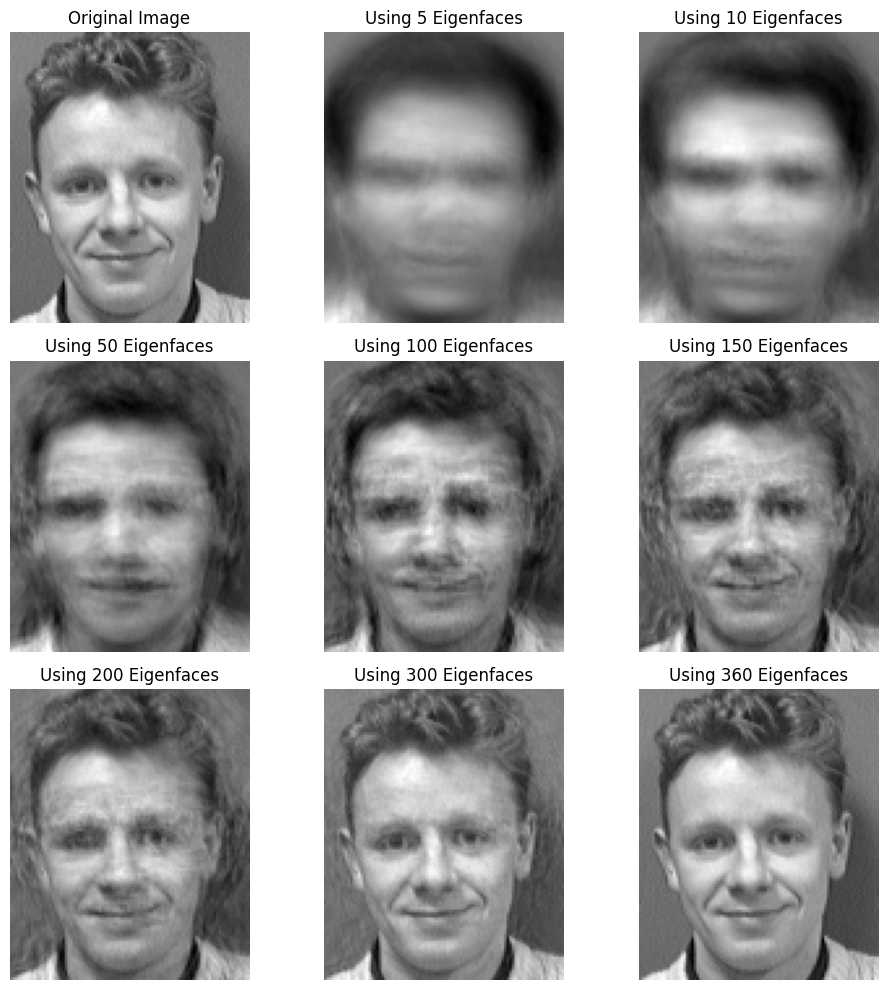

In [17]:
reconstructed_image = deepcopy(average_face)
reconstructed_images = np.zeros((len(coefficients), eigenfaces.shape[0]))  # for visualization

for i in range(len(coefficients)):
    reconstructed_image += coefficients[i] * eigenfaces[:, i]
    reconstructed_images[i, :] = reconstructed_image

plt.figure(figsize=(10, 10))

plt.subplot(3, 3, 1)
plt.imshow(original_image.reshape(112, 92), cmap='gray')
plt.title('Original Image')
plt.axis('off')

eigenface_counts = [5, 10, 50, 100, 150, 200, 300, 360] 

for idx, count in enumerate(eigenface_counts):
    plt.subplot(3, 3, idx + 2)
    plt.imshow(reconstructed_images[count - 1, :].reshape(112, 92), cmap='gray')
    plt.title(f'Using {count} Eigenfaces')
    plt.axis('off')

plt.tight_layout()
plt.show()